# Implementing and using a new *contrast* with `pygosa`

The benefit ot the module is to make easy the definition a new contrast class (see for example [New sensitivity analysis subordinated to a contrast](http://www.math.univ-toulouse.fr/~klein/Gosa.pdf)

Implementing such contrast and apply it within the `pygosa` module relies on:

  - The definintion of a new class that inherites from `ContrastSensitivityClass`;
  - The definintion of the internal `contrast` method as function of `y` and `t`;
  - The definintion of the `get_risk_value` method as function that takes into account a data sample and returns the 
    quantity of interest;

Of course, the underlying contrast should be associated to the quantity of interest defined in `get_rist_value`. As an example, we illustrate how to define the `mean contrast` class in less than 10 lines and applying the contrast to compute the sensitivity factors:

In [1]:
import openturns as ot
import numpy as np
import pygosa
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We define `Sobol` use-case, which is very common in case of sensitivity analysis:

In [2]:
model = ot.SymbolicFunction(["x1","x2","x3"], ["sin(x1) + 7*sin(x2)^2 + 0.1*(x3^4)*sin(x1)"])
dist = ot.ComposedDistribution( 3 * [ot.Uniform(-np.pi, np.pi)] )

## Design of experiment

We define the experiment `design`. The benefits of using a `crude` Monte-Carlo approach is the potential use of several contrasts.

In [3]:
mcsp = pygosa.SensitivityDesign(dist=dist, model=model, size=5000)

## Moment of second order 

Hereafter we define a new contrast class that helps evaluating sensitivities of $\mathbb{E}(Y^2)$. The contrast class should :

 - Inherits from `ContrastSensitivityAnalysis`
 - Define the `contrast` method with signature `contrast(self, y,t, **kwargs)`. It should have `kwargs` as arguments even if not used
 - Define the `get_risk_value` method with signature `get_risk_value(self, data, **kwargs)`. Same remark concerning **kwargs**


In [4]:
class Moment2SA(pygosa.ContrastSensitivityAnalysis):
    def __init__(self, design):
        super(Moment2SA, self).__init__(design)

    # contrast method
    def contrast(self, y,t, **kwargs):
        """
        Contrast for moment of second order
        """
        return (y*y-t)*(y*y-t)

    # Define risk function (second order moment)
    # moments2 = var + mean * mean
    def get_risk_value(self, data, **kwargs):
        mu = ot.Sample(data).computeMean()
        var =  ot.Sample(data).computeVariance()
        return np.array(mu) * np.array(mu) + np.array(var)


The previous class is a contrast similar to those provided by the module. We can thus easily apply it using the previous design:

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


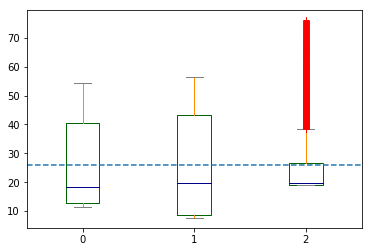

In [5]:
sam = Moment2SA(mcsp)
factors_m = sam.compute_factors()
fig, ax = sam.boxplot()

In [6]:
print(factors_m)

[[ 0.21166235  0.28014466  0.12583268]]
